# Exploratory Data Analysis

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns


### Import Data

In [2]:
path = os.getcwd()
path = path.replace('EDA', 'data_preprocessing')
files = os.listdir(path)
for file in files:
    if len(file.split('.csv'))>1:
        csv_path = path+'/'+file
data = pd.read_csv(csv_path)
data['date']=pd.to_datetime(data['date'])

In [3]:
data.head()

,date,domestic_market_contract_low,export_market_spot,domestic_market_spot,wtisplc,mcoilbrenteu,gasregm,impch,expch,prubbusdm,...,brazil_export,germany_export,united_kingdom_export,canada_import,usa_import,india_import,south_africa_import,germany_import,united_kingdom_import,japan_import
0,2000-01-01,41.0,NaN,NaN,27.18,25.51,1.289,6902.1,863.1,29.207387,...,10352529.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-02-01,41.0,NaN,NaN,29.35,27.78,1.377,6584.4,972.7,33.391099,...,8844172.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-03-01,45.0,NaN,NaN,29.89,27.49,1.516,6424.1,1330.5,30.941913,...,14091209.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-04-01,47.0,NaN,NaN,25.74,22.76,1.465,7070.5,1227.5,31.930148,...,14097518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-05-01,47.0,NaN,NaN,28.78,27.74,1.487,7850.2,1526.3,31.201702,...,16762995.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### EDA for univariate ARIMA

In [4]:
uv_data = data[data.columns[:2]].set_index(data.columns[0])
uv_data =  uv_data.rename(columns = {data.columns[1]:'target'})
uv_data

,target
date,
2000-01-01,41.0
2000-02-01,41.0
2000-03-01,45.0
2000-04-01,47.0
2000-05-01,47.0
...,...
2022-08-01,93.0
2022-09-01,90.0
2022-10-01,90.0


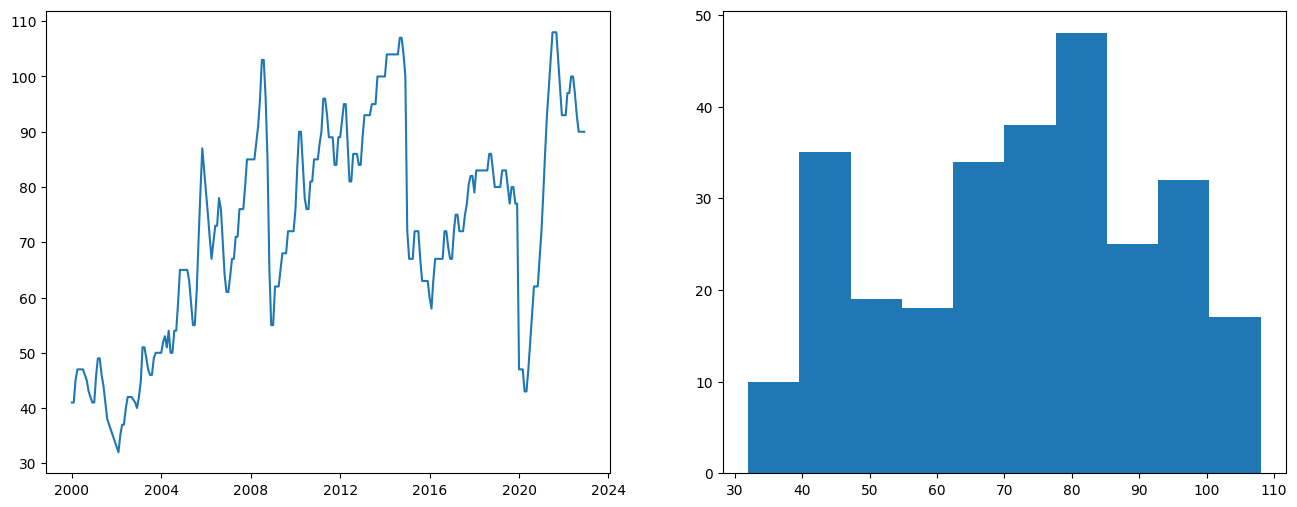

In [5]:
plt.figure(figsize = (16,6))

plt.subplot(1,2,1)
plt.plot(uv_data['target'])
plt.subplot(1,2,2)
plt.hist(uv_data['target'])
plt.show()

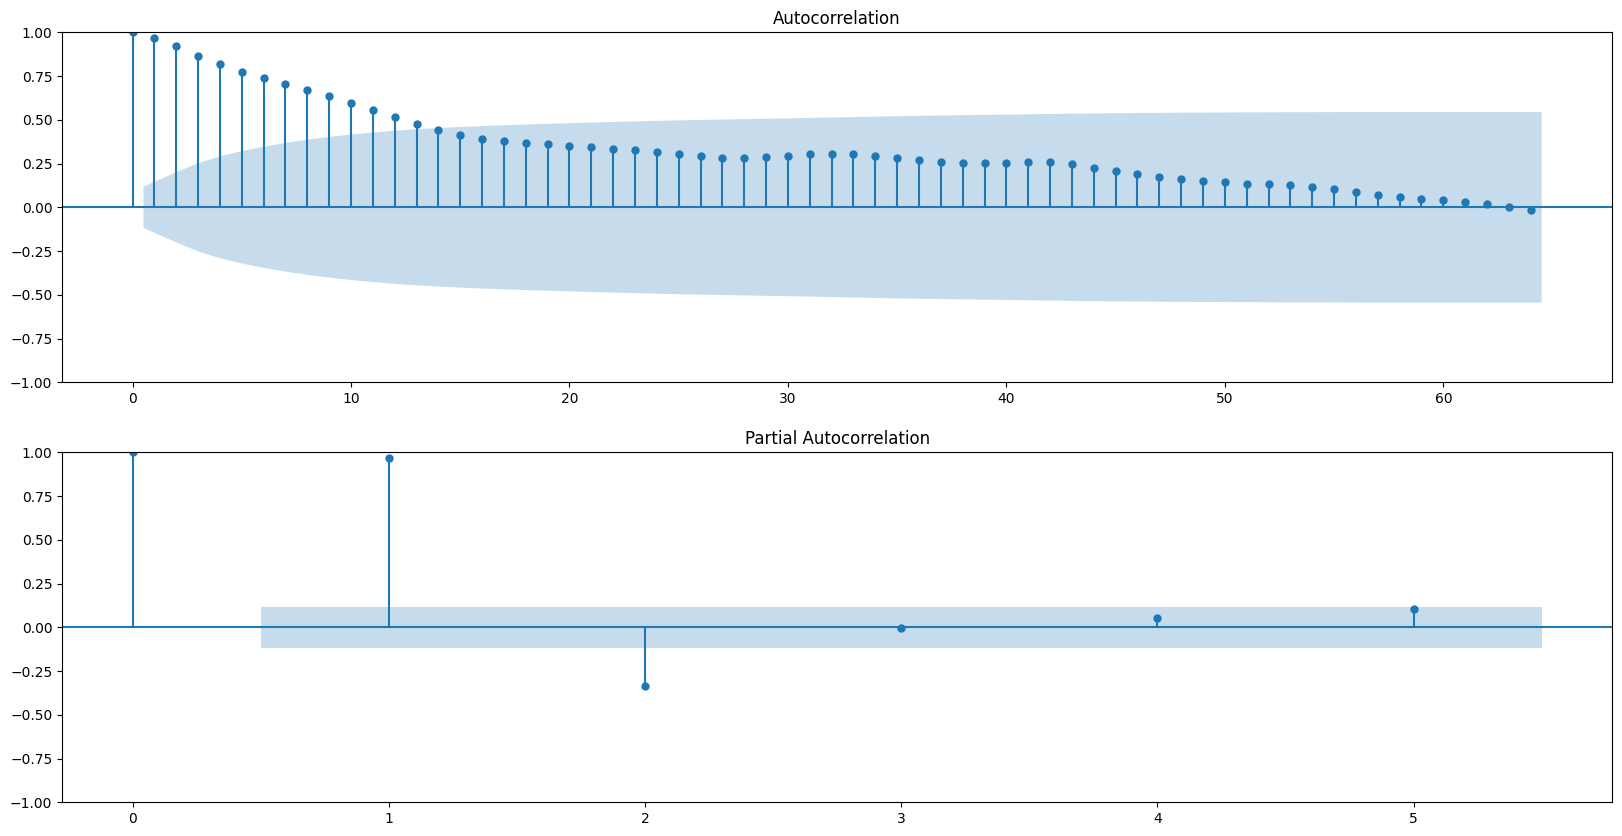

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10))

# Plot the ACF of the differenced series
plot_acf(uv_data, ax=ax1,lags=64)

# Plot the PACF of the differenced series
plot_pacf(uv_data, ax=ax2,lags=5)

plt.show()

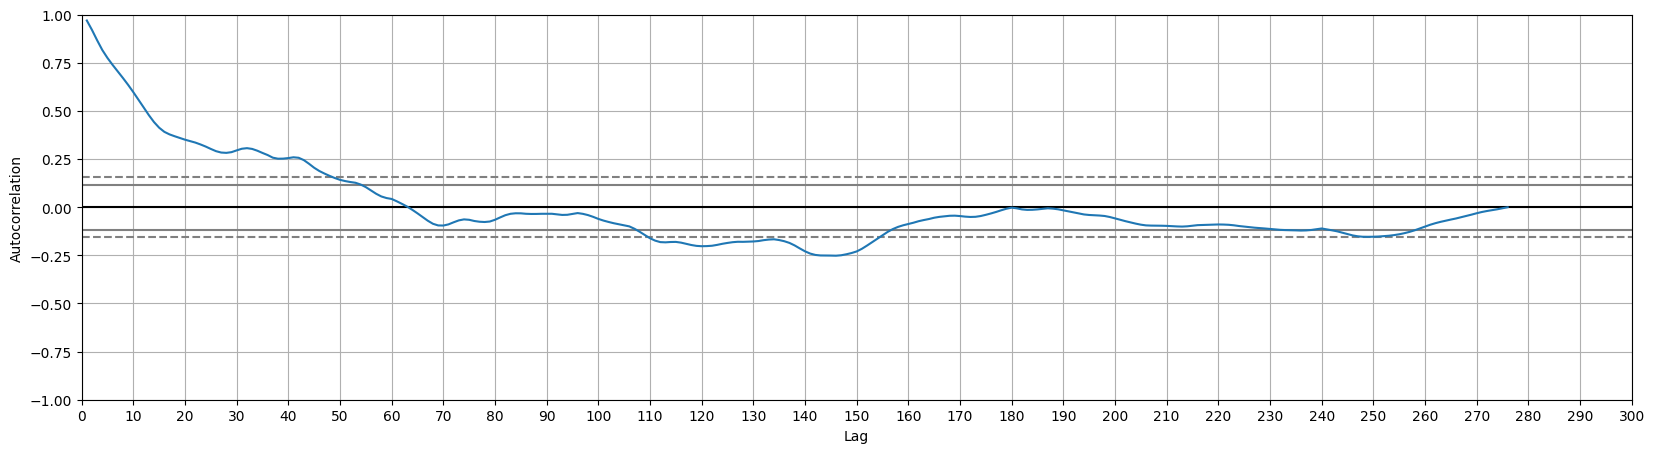

In [7]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20, 5))
autocorrelation_plot(uv_data['target'])
existing_ticks = plt.xticks()[0]
new_ticks = np.linspace(existing_ticks.min(), existing_ticks.max(), 31 )
plt.xticks(new_ticks)

plt.show()

In [8]:
# ARIMA requires the data to be stationary. We can check this by using Augmented Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller
result = adfuller(uv_data['target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.238045
p-value: 0.192728


Since, ADF value > -2.87 and p-value >0.05 we fail to reject the null-hypothesis that the time series is not stationary.

In [9]:
data_diff = uv_data.diff().dropna()
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_diff['target'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.399522
p-value: 0.000000


With a difference of one . the data has becoe stationary and we can reject the null hypothesis.

### We can check for seasonality as well.

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_diff, model='additive')  # or 'multiplicative'
decomposition.plot()
plt.show()

####  Time Series Decomposition

##### Original Data

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
decomposition = seasonal_decompose(uv_data['target'], model='additive')

# Access the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

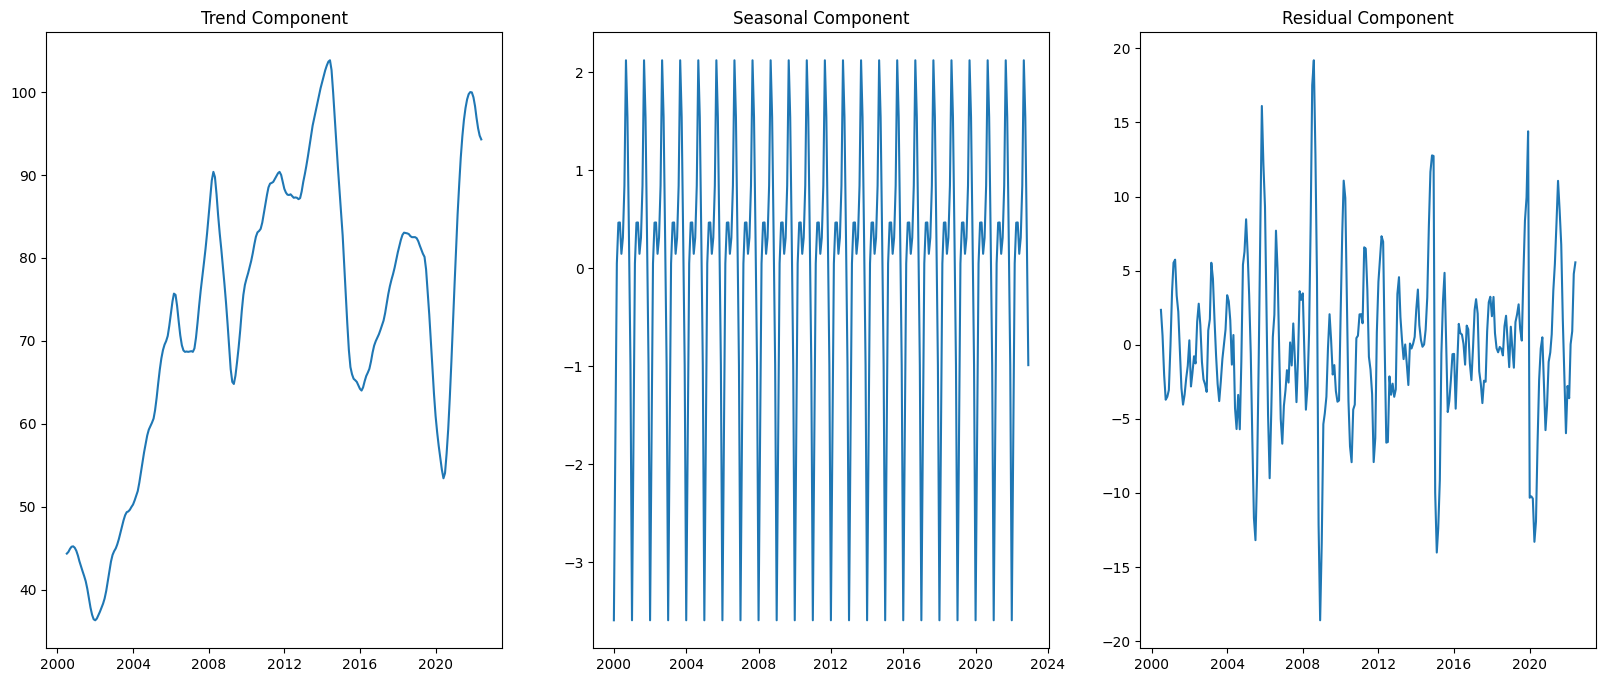

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(trend)
plt.title('Trend Component')
plt.subplot(1,3,2)
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.subplot(1,3,3)
plt.plot(residual)
plt.title('Residual Component')

plt.show()

* Other than a general upward movement, there is no clear indication of a trend.

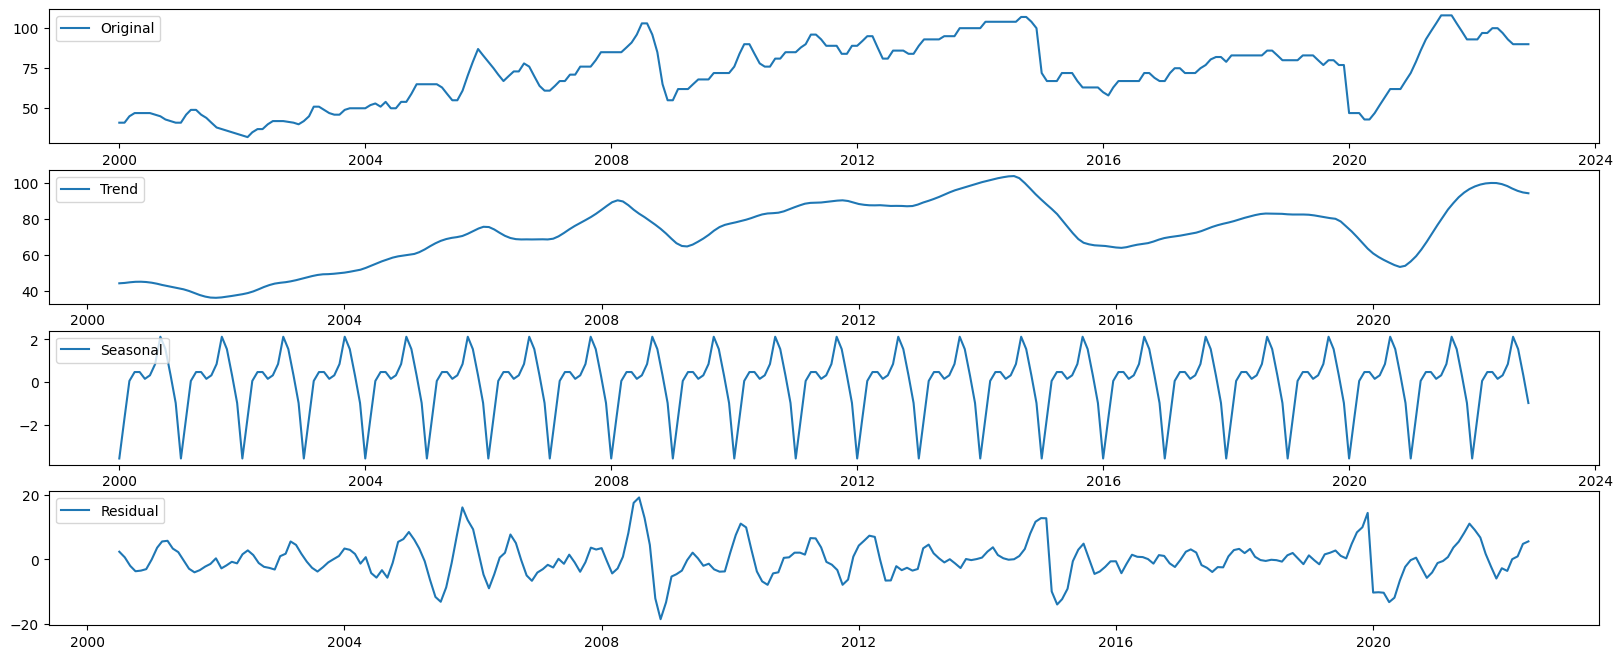

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(411)
plt.plot(uv_data['target'], label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc='upper left')
plt.show()


##### Differenced Data

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time series decomposition
decomposition = seasonal_decompose(data_diff['target'], model='additive')

# Access the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

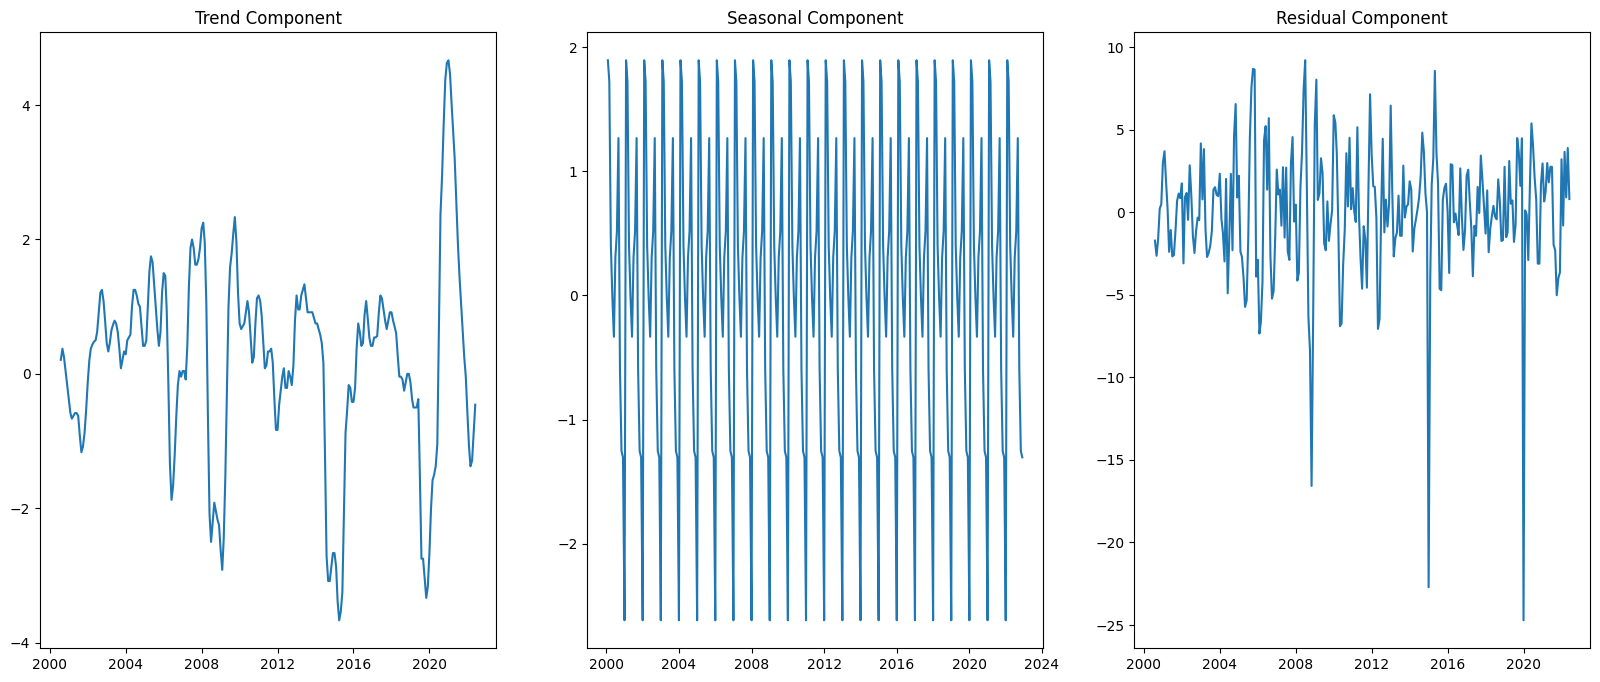

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(trend)
plt.title('Trend Component')
plt.subplot(1,3,2)
plt.plot(seasonal)
plt.title('Seasonal Component')
plt.subplot(1,3,3)
plt.plot(residual)
plt.title('Residual Component')

plt.show()

### Identify order of the AR (autoregressive), I (integrated), and MA (moving average) processes, along with the seasonal components.

p: The lag value where the PACF cuts off (drops to 0) for the first time.
q: The lag value where the ACF chart crosses the upper confidence interval for the first time.
d: The order of differencing required to make the time series stationary.

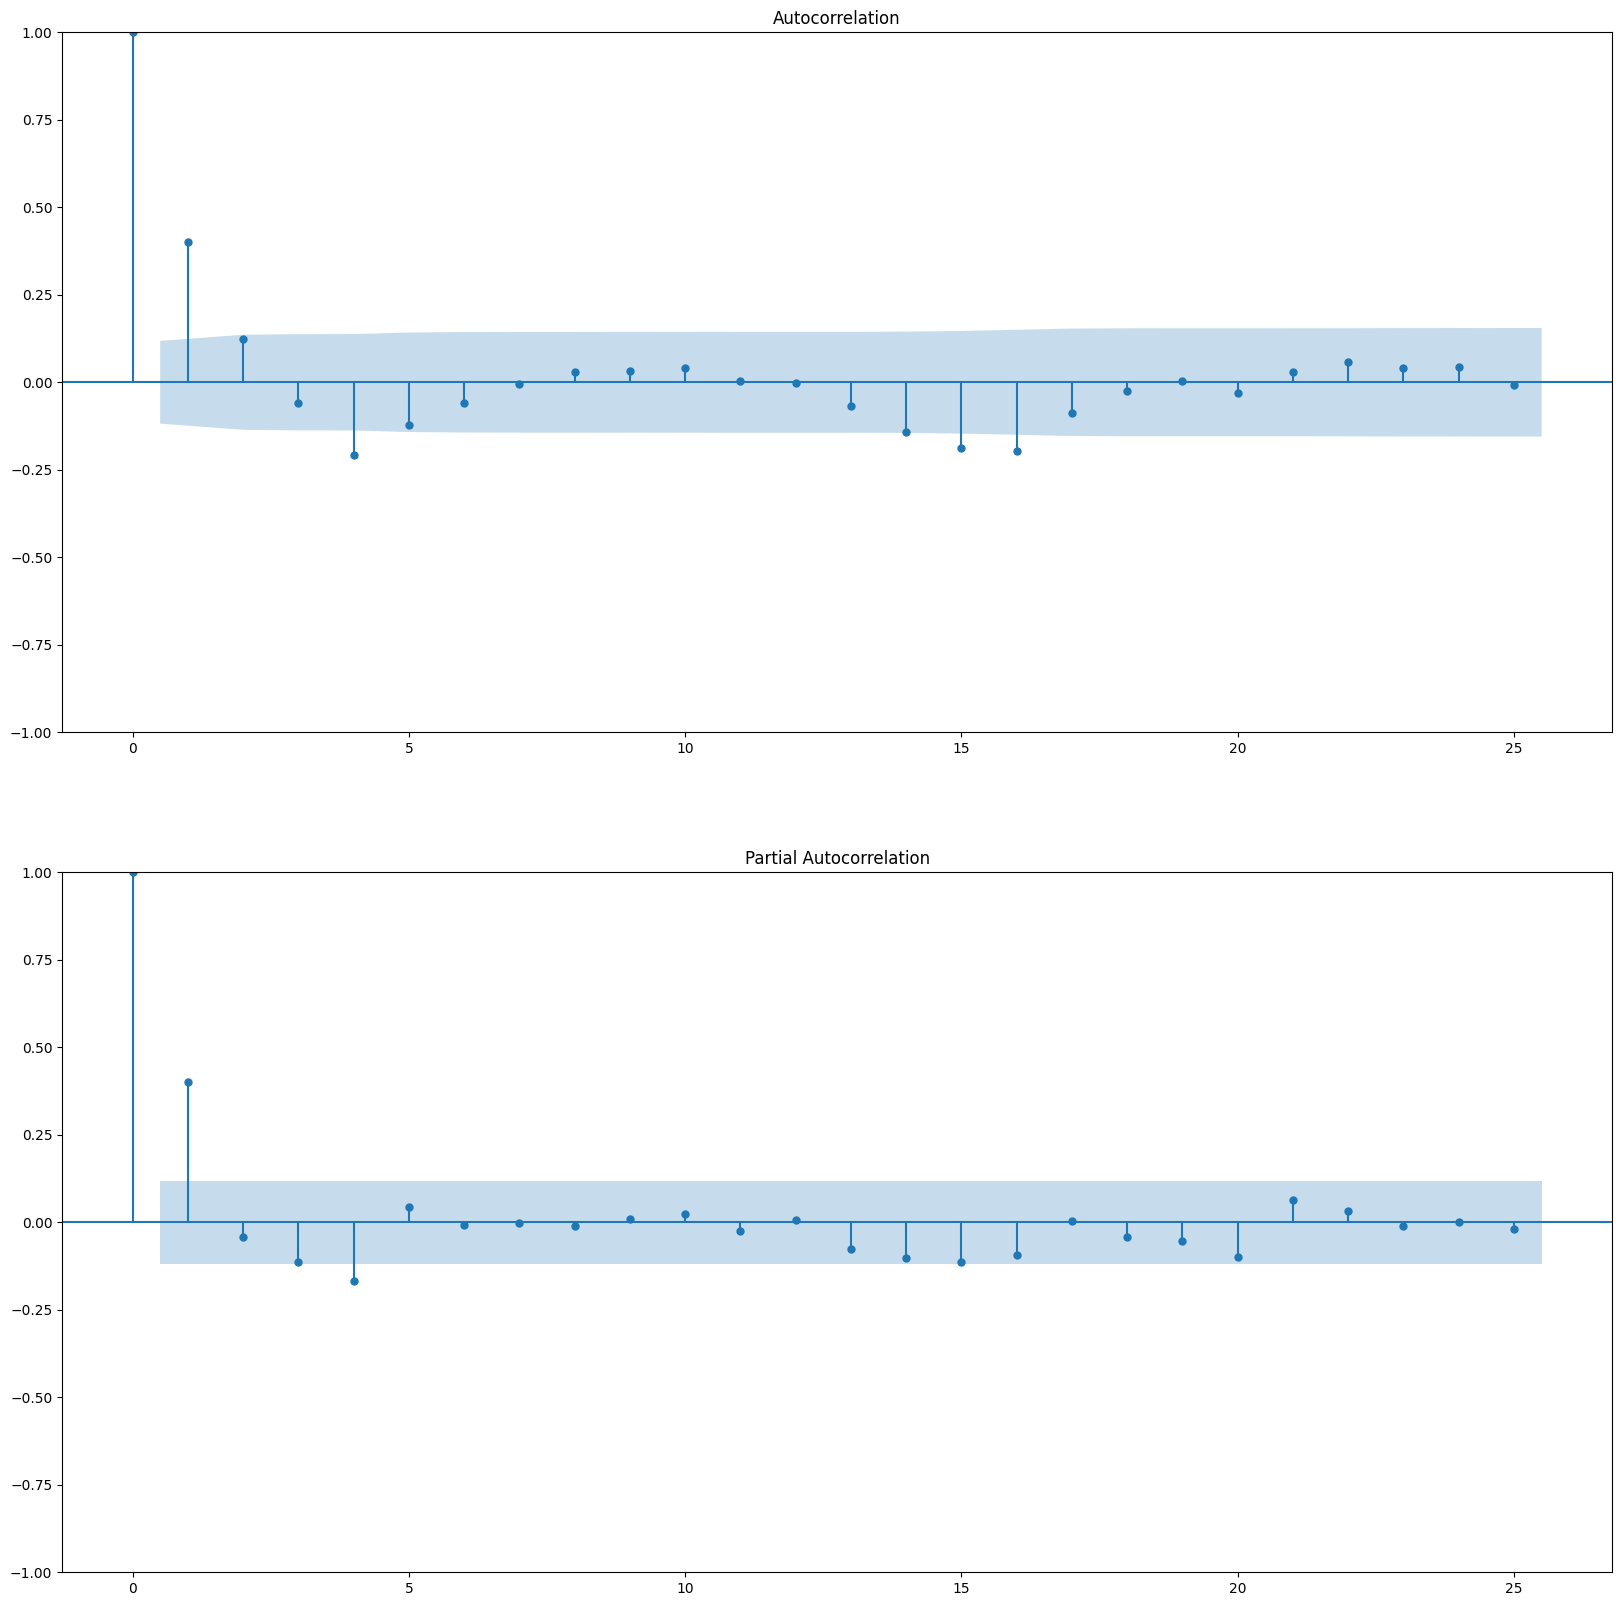

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,20))

# Plot the ACF of the differenced series
plot_acf(data_diff, ax=ax1,)

# Plot the PACF of the differenced series
plot_pacf(data_diff, ax=ax2)

plt.show()

In [16]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function
stepwise_fit = auto_arima(data_diff['target'], seasonal=True, m=12,
                          suppress_warnings=True, 
                          error_action="ignore", max_order=None, stepwise=True)

# To print the summary
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  275
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -758.797
Date:                Tue, 06 Jun 2023   AIC                           1525.593
Time:                        13:19:22   BIC                           1540.060
Sample:                    02-01-2000   HQIC                          1531.399
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3465      0.047     28.558      0.000       1.254       1.439
ar.L2         -0.4283      0.035    -12.395      0.000      -0.496      -0.361
ma.L1         -0.9513      0.045    -21.211      0.000      -1.039      -0.863
sigma2        14.5691      0.404     36.026      0.000      13.776      15.362
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              5924.73
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Data from before differencing.

In [17]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Fit auto_arima function
stepwise_fit = auto_arima(uv_data['target'],  seasonal=True, m=12,
                          suppress_warnings=True, 
                          error_action="ignore", max_order=None, stepwise=True)

# To print the summary
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  276
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -758.797
Date:                Tue, 06 Jun 2023   AIC                           1525.593
Time:                        13:19:27   BIC                           1540.060
Sample:                    01-01-2000   HQIC                          1531.399
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3465      0.047     28.558      0.000       1.254       1.439
ar.L2         -0.4283      0.035    -12.395      0.000      -0.496      -0.361
ma.L1         -0.9513      0.045    -21.211      0.000      -1.039      -0.863
sigma2        14.5690      0.404     36.026      0.000      13.776      15.362
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              5924.73
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               2.58   Skew:                            -3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

p = 2
d = 1
q = 1
 from Auto ARIMA 

### Analysis of global Trends

In [18]:
uv_data['year']=[d.year for d in uv_data.index]
uv_data['month']=[d.strftime('%b') for d in uv_data.index]
uv_data.head(3)

,target,year,month
date,,,
2000-01-01,41.0,2000,Jan
2000-02-01,41.0,2000,Feb
2000-03-01,45.0,2000,Mar


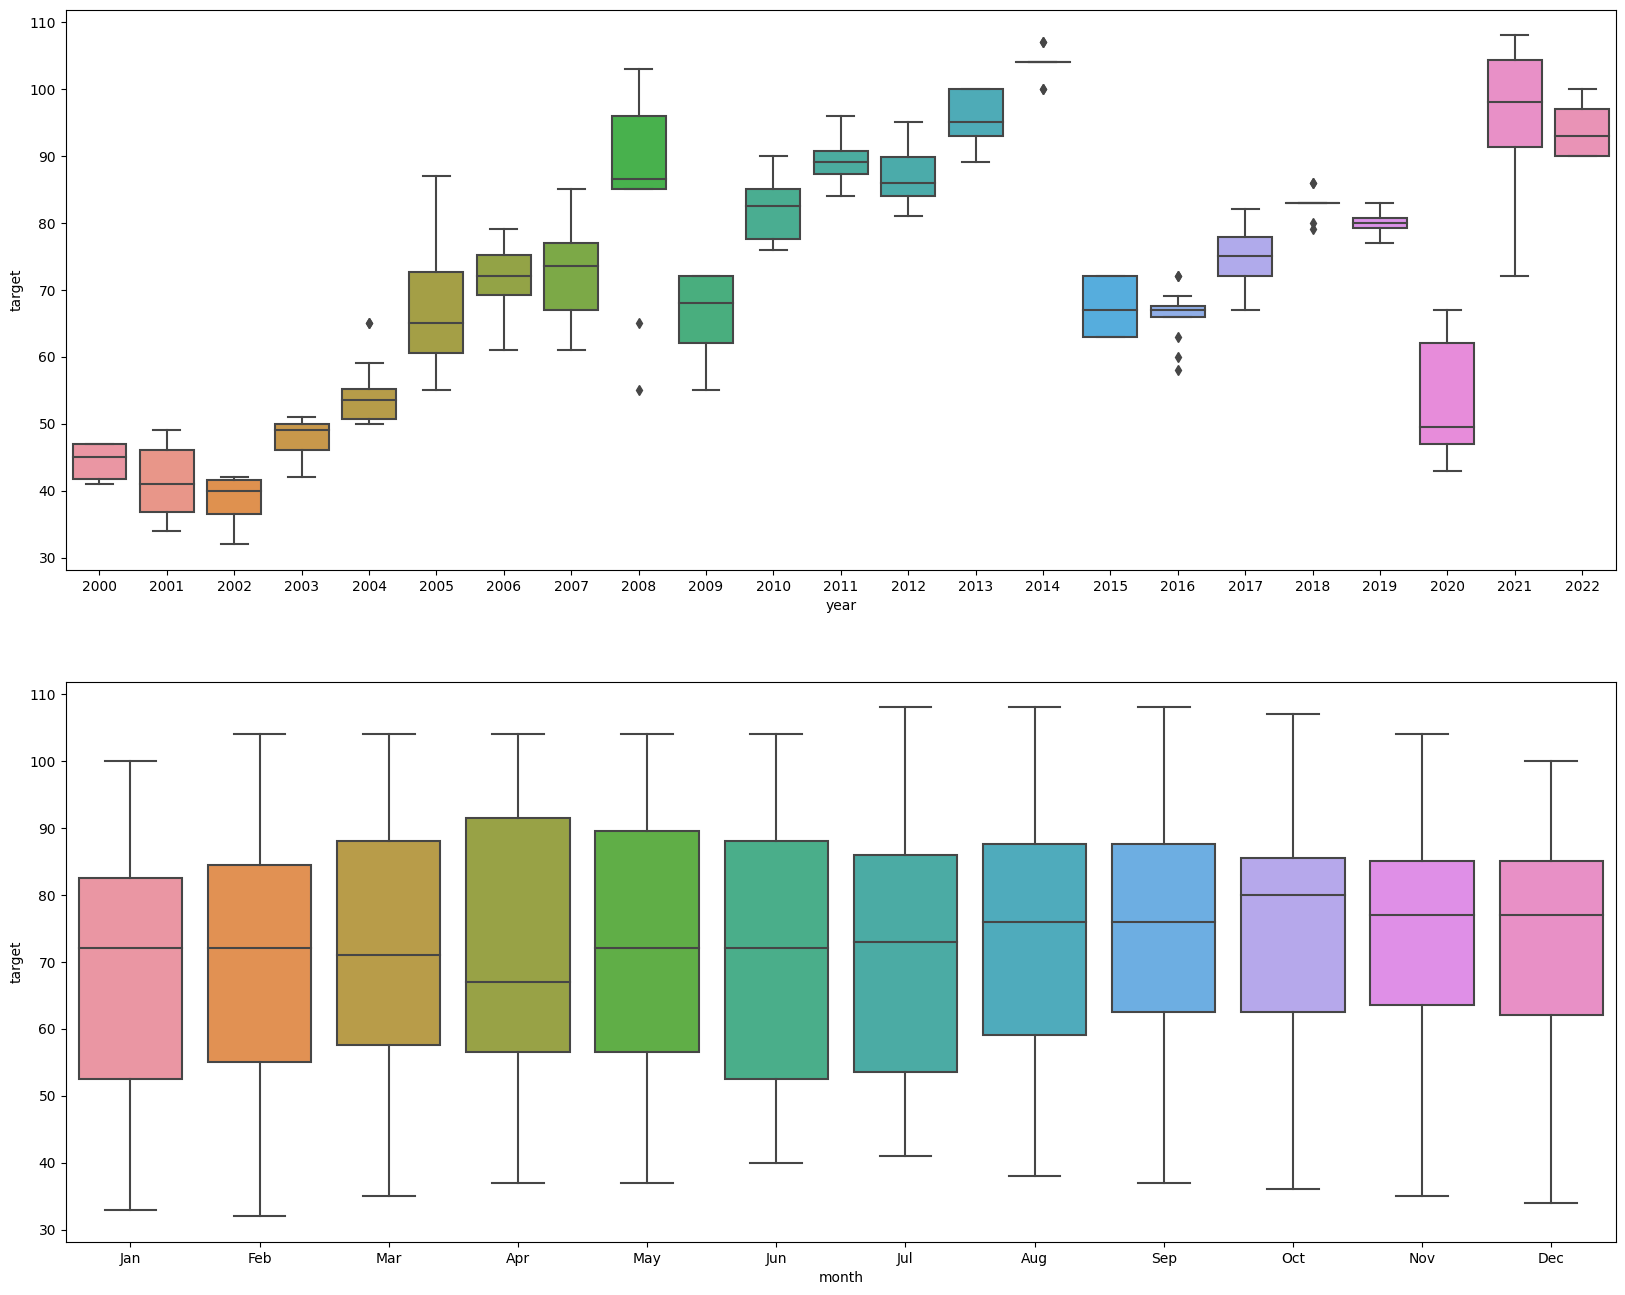

In [19]:
plt.figure(figsize=(20,16))
plt.subplot(211)
sns.boxplot(x='year', y='target', data=uv_data)
plt.subplot(212)
sns.boxplot(x='month', y='target', data=uv_data)
plt.show()

In [20]:
statistics = uv_data.groupby('year')['target'].agg({'mean', 'median', 'sum'})
statistics.columns = ['mean', 'median', 'sum']
statistics

,mean,median,sum
year,,,
2000,532.0,45.0,44.333333
2001,496.0,41.0,41.333333
2002,462.5,40.0,38.541667
2003,576.0,49.0,48.000000
2004,657.0,53.5,54.750000
2005,807.5,65.0,67.291667
2006,857.0,72.0,71.416667
2007,879.0,73.5,73.250000
2008,1037.0,86.5,86.416667


From the data provided, it seems there are several shifts in the domestic blow molding market price that appear to coincide with notable historical events. 

#### Plots

2000-2002: This downward trend in prices could be related to the fallout of the dot-com bubble bursting around this time, which had broad implications for the global economy.

2002-2007: The recovery and growth during these years could be due to several factors, including a period of economic expansion in many developed nations following the early 2000s recession.

2008: The spike in 2008 may be related to the global financial crisis. Economic uncertainty can lead to market volatility and unpredictable price movements. The crisis might have caused a surge in demand for certain materials or industries, leading to this price increase.

2009: The sharp drop here aligns with the global economic recession that followed the 2008 financial crisis.

2009-2014: The subsequent rise may reflect a period of economic recovery and growth post-recession.

2014: The singular line for 2014 suggests no variability in the data for this year, which is quite unusual for a time series dataset.

2014-2015: This significant dip could be associated with a variety of global events. Around this time, there were numerous significant geopolitical events, such as the ongoing conflict in the Middle East and the start of the Russia-Ukraine conflict.

2018: Similar to 2014, the lack of variability in the data here is unusual.

2020: The big dip in this year can be attributed to the COVID-19 pandemic, which had a huge impact on global economies and supply chains. Many industries saw drastic changes in demand patterns, leading to price fluctuations.

2021-2022: The recovery and increase in price during these years might reflect a rebounding global economy as nations recover from the impacts of the pandemic. 

#### Statistics

Mean: The mean price is quite informative as it provides a general measure of central tendency. In general, it appears that mean prices have experienced significant fluctuations over the years, which suggests a high degree of variability in the market. However, the mean is sensitive to extreme values and does not always reflect the typical price, especially in a volatile market.

Median: The median price provides another measure of central tendency, and because it's less sensitive to extreme values than the mean, it may be more representative of the "typical" price in a given year. In most years, the median and mean are quite close, suggesting a symmetric distribution of prices. Notable exceptions occur in years like 2020, where the median is lower than the mean, suggesting a skew in the distribution.

Sum: The sum of prices per year can reflect both the price levels and the number of transactions (assuming each entry corresponds to a transaction) in each year. However, without more context, it's difficult to interpret the sum. It could be influenced by many factors such as changes in demand, supply, the number of producers, or market dynamics.

The significant drops in 2009 and 2020 in all three measures - mean, median, and sum - align with global financial crises and the COVID-19 pandemic, respectively, suggesting these events may have affected not only the typical price (mean, median) but also the overall level of activity in the market (sum).

The coinciding values of mean, median, and identical quartiles in 2014 and 2018 suggest there's no variation in the data for these years. It's quite unusual and may be due to some data collection error or some other external factor causing prices to stay unusually stable.

The year 2021 and 2022 seems to reflect a recovery phase in the market after the dip in 2020 due to the pandemic. The median and mean values have gone up compared to 2020, showing a general increase in prices.